In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS =50


In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
#for get 3 classes of images
class_names = dataset.class_names
class_names

#these classes index as 0, 1 and 2

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

In [6]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 1 2 2 1 1 0 0 0 1 0 0 1 0 1 0 2 0 0 1 0 1 1 1 1 1 1 1 1]


In [7]:
#for the first image
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].numpy())

[[[204. 179. 175.]
  [132. 107. 103.]
  [156. 131. 127.]
  ...
  [182. 161. 158.]
  [157. 136. 133.]
  [160. 139. 136.]]

 [[128. 103.  99.]
  [119.  94.  90.]
  [112.  87.  83.]
  ...
  [177. 156. 153.]
  [141. 120. 117.]
  [129. 108. 105.]]

 [[172. 147. 143.]
  [160. 135. 131.]
  [140. 115. 111.]
  ...
  [142. 121. 118.]
  [141. 120. 117.]
  [166. 145. 142.]]

 ...

 [[133. 105. 102.]
  [120.  92.  89.]
  [117.  89.  86.]
  ...
  [130. 108. 110.]
  [141. 119. 121.]
  [133. 111. 113.]]

 [[140. 112. 109.]
  [129. 101.  98.]
  [127.  99.  96.]
  ...
  [125. 103. 105.]
  [142. 120. 122.]
  [134. 112. 114.]]

 [[123.  95.  92.]
  [133. 105. 102.]
  [135. 107. 104.]
  ...
  [120.  98. 100.]
  [135. 113. 115.]
  [122. 100. 102.]]]


In [8]:
#for the first image
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].shape)

(256, 256, 3)


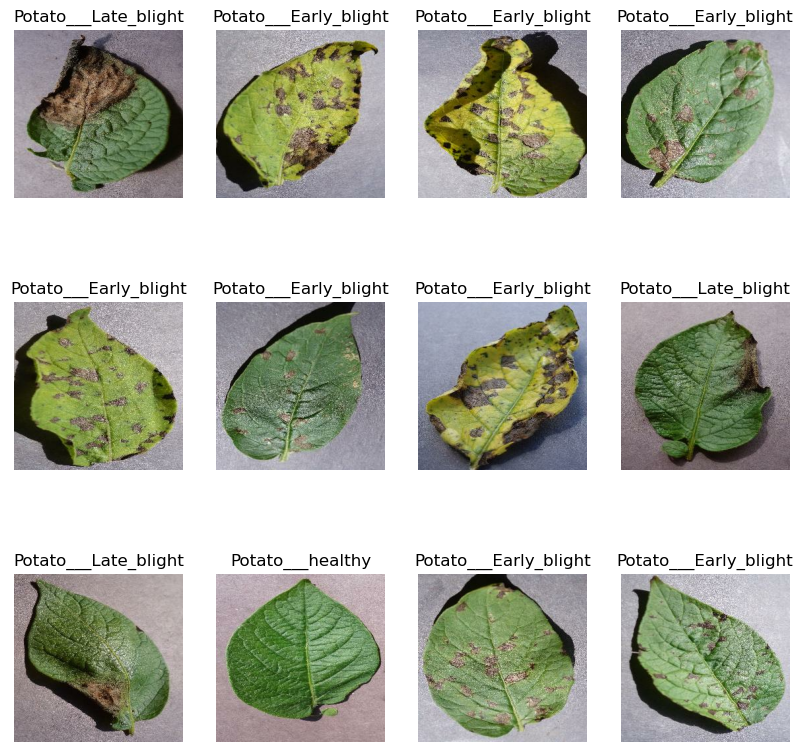

In [9]:
#for visualize images
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")
   

In [10]:
#SPLIT data train and test

#tarin = 0.8
#test  = validation 10%   test 10%
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [11]:
train_ds = dataset.take(54)
len(train_ds)

54

In [12]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [13]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [14]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [15]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [16]:
#split 
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1,test_split=0.1, shuffle = True, shuffle_size=10000):
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, train_ds

In [17]:
train_ds, val_ds, train_ds = get_dataset_partitions_tf(dataset)

In [18]:
#prefetch
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [19]:
#scale
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
    
])

In [20]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_And_verticle"),
    layers.RandomRotation(0.2)   
])

In [21]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3  #model architecture has 3 neurons

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),  # Add dropout to reduce overfitting
    layers.Dense(n_classes, activation='softmax')
])
    
model.build(input_shape=input_shape)    

d:\Anaconda\envs\ds_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [42]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (32, 246016)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (32, 128)              │    31,490,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (32, 128)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (32, 3)                │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,509,955 (120.20 MB)

 Trainable params: 31,509,955 (120.20 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
    )


In [23]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds,
    validation_steps = int(0.1 * len(val_ds))
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.5713 - loss: 5.3799 - val_accuracy: 0.8594 - val_loss: 0.4485
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.8315 - loss: 0.4824 - val_accuracy: 0.8385 - val_loss: 0.3842
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.8368 - loss: 0.4439 - val_accuracy: 0.8698 - val_loss: 0.2801
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.8903 - loss: 0.2999 - val_accuracy: 0.8698 - val_loss: 0.3869
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.8615 - loss: 0.3670 - val_accuracy: 0.8802 - val_loss: 0.2189
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.8946 - loss: 0.2433 - val_accuracy: 0.9115 - val_loss: 0.2339
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.9001 - loss: 0.2578 - val_accuracy: 0.9635 - val_loss: 0.1516
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.9286 - loss: 0.1950 - val_accuracy: 0.9688 - val_l

In [24]:
history

In [25]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [26]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Losses')

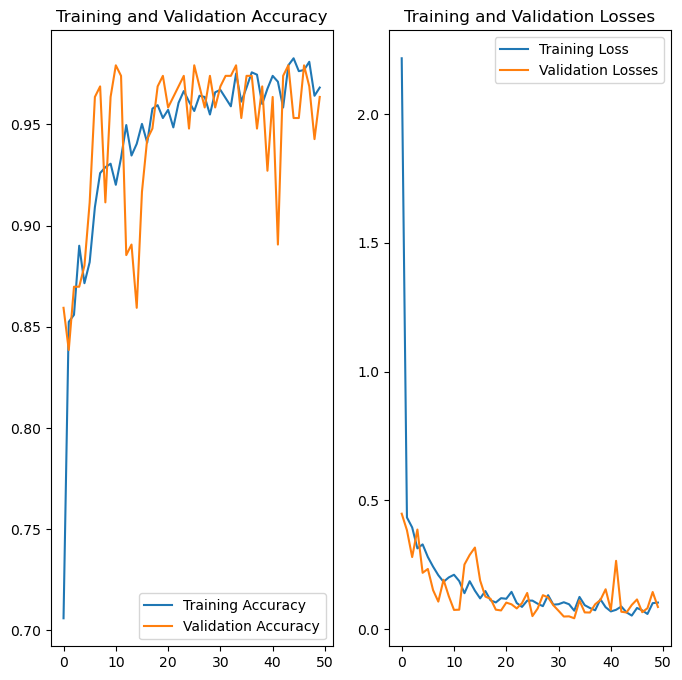

In [28]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Losses')
plt.legend(loc='upper right')
plt.title('Training and Validation Losses')

first image to predict
actual label: Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
predicted label: Potato___Late_blight


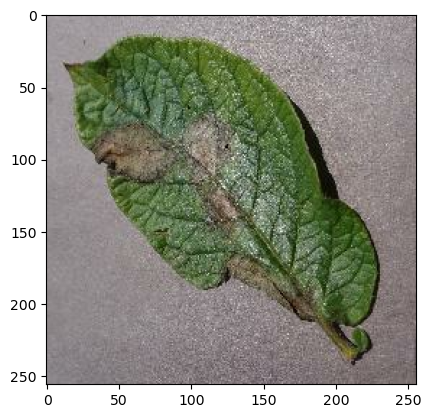

In [29]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:", class_names[first_label])
    batch_prediction = model.predict(image_batch)
    print("predicted label:", class_names[np.argmax(batch_prediction[0])])

In [36]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images_batch[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])), 2)
    return predicted_class, confidence

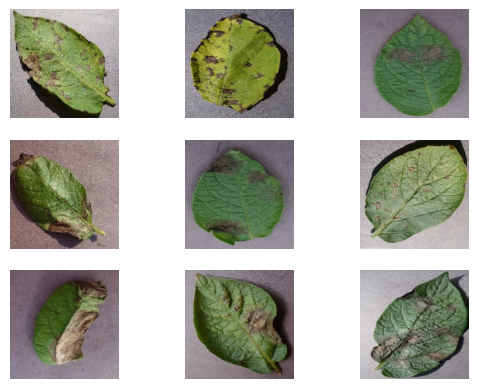

In [37]:
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

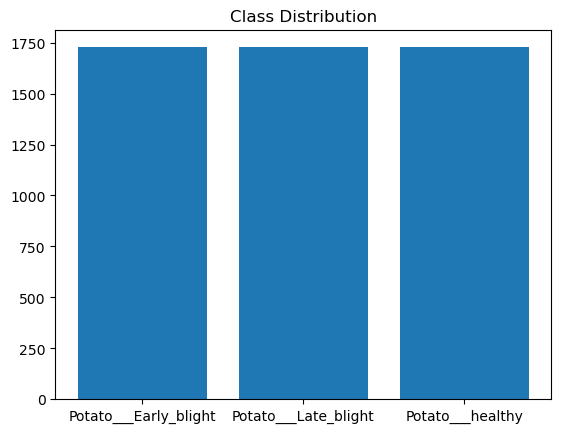

In [40]:
import matplotlib.pyplot as plt

class_counts = {}
for images, labels in train_ds:
    for label in labels:
        cls = np.argmax(label)  # For one-hot encoded labels
        class_counts[cls] = class_counts.get(cls, 0) + 1

plt.bar(class_names, list(class_counts.values()))
plt.title("Class Distribution")
plt.show()